In [1]:
import pyfastchem as pyfc
import os
import petitRADTRANS.physical_constants as nc

import numpy as np
import matplotlib.pyplot as plt

os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
class FastChemistry():

    def __init__(self, pressures, rainout=True, **kwargs):

        self.pressures = pressures

        pyfc_path = os.path.abspath('/net/lem/data1/regt/fastchem/')
        self.element_file = f'{pyfc_path}/input/element_abundances/' + kwargs.get('element_file', 'bergemann_2025_protosolar.dat')
        self.logK_gas_file = f'{pyfc_path}/input/logK/' + kwargs.get('logK_gas_file', '2024-11-21_logK_li_ge.dat')
        self.logK_cond_file = f'{pyfc_path}/input/logK/' + kwargs.get('logK_cond_file', 'logK_new_cond_li_ge.dat')

        self.fastchem = pyfc.FastChem(
            self.element_file, self.logK_gas_file, self.logK_cond_file, 0
            )

        # Create in/out-put structures for FastChem
        self.input = pyfc.FastChemInput()
        self.input.pressure = self.pressures[::-1] # Flip to decrease

        self.output = pyfc.FastChemOutput()

        # Use equilibrium condensation
        # Use rainout condensation approach
        self.input.equilibrium_condensation = True
        self.input.rainout_condensation     = rainout

        # Configure FastChem's internal parameters
        self.fastchem.setParameter('accuracyChem', 1e-6)
        self.fastchem.setParameter('accuracyElementConservation', 1e-6)
        
        self.fastchem.setParameter('nbIterationsChem', 100000)
        # ------------------------------------------------------------------

        # Make a copy of the solar abundances from FastChem
        self.solar_abundances = np.array(self.fastchem.getElementAbundances())

        # Indices of carbon-bearing species
        self.index_C = np.array(self.fastchem.getElementIndex('C'))
        self.index_O = np.array(self.fastchem.getElementIndex('O'))

        self.index_Li = np.array(self.fastchem.getElementIndex('Li'))

        # Compute the solar C/O ratio
        self.CO_solar = self.solar_abundances[self.index_C] / \
            self.solar_abundances[self.index_O]

        # Indices of H/He-bearing species
        index_H  = np.array(self.fastchem.getElementIndex('H'))
        index_He = np.array(self.fastchem.getElementIndex('He'))

        self.mask_metal = np.ones_like(self.solar_abundances, dtype=bool)
        self.mask_metal[index_H]  = False
        self.mask_metal[index_He] = False

    def get_VMR(self, species_i):
        index = self.fastchem.getGasSpeciesIndex(species_i)
        if index > self.fastchem.getGasSpeciesNumber():
            return np.nan * self.gas_number_density_tot
        gas_number_density = np.array(self.output.number_densities)[::-1,index]
        return (gas_number_density / self.gas_number_density_tot)
    
    def get_condensate_number_density(self, species_i):
        index = self.fastchem.getCondSpeciesIndex(species_i)
        return np.array(self.output.number_densities_cond)[::-1,index]
    
    def get_element_cond_degree(self, element_i):
        index = self.fastchem.getElementIndex(element_i)
        return np.array(self.output.element_cond_degree)[::-1,index]
    
    def get_element_number_density(self, element_i):
        index = self.fastchem.getElementIndex(element_i)
        total_element_density  = np.array(self.output.total_element_density)[::-1]
        total_element_density *= np.array(self.fastchem.getElementAbundance(index)) / np.sum(self.fastchem.getElementAbundances())
        return (total_element_density / self.gas_number_density_tot)

    def __call__(self, T, CO=None, LiF=None, FeH=0., el_abund={'Li':10**(3.28-12)}, min_T=100.):

        temperature = T * np.ones_like(self.pressures)
        if (temperature < min_T).any():
            print(f'Replaced T<{min_T} with T={min_T} K')
            temperature[temperature<min_T] = min_T

        self.input.temperature = temperature[::-1] # Flip for FastChem usage

        # Make a copy to modify the elemental abundances
        element_abundances = self.solar_abundances.copy()
        metallicity_wrt_solar = 10**FeH

        for element_i in el_abund.keys():
            index = self.fastchem.getElementIndex(element_i)
            element_abundances[index] = el_abund[element_i]

        # Apply C/O ratio and Fe/H to elemental abundances
        if CO is not None:
            CO_correction = (1 + element_abundances[self.index_C]/element_abundances[self.index_O]) / (1+CO)
            element_abundances[self.index_C] = element_abundances[self.index_O] * CO
            element_abundances[self.index_C] *= CO_correction
            element_abundances[self.index_O] *= CO_correction

        if LiF is not None:
            index_F = self.fastchem.getElementIndex('F')
            LiF_correction = (1 + element_abundances[self.index_Li]/element_abundances[index_F]) / (1+LiF)
            element_abundances[self.index_Li] = element_abundances[index_F] * LiF
        #     element_abundances[self.index_Li] *= LiF_correction
        #     element_abundances[index_F]       *= LiF_correction

        element_abundances[self.mask_metal] *= metallicity_wrt_solar

        # Update the element abundances
        self.fastchem.setElementAbundances(element_abundances)

        # Compute the number densities
        fastchem_flag = self.fastchem.calcDensities(self.input, self.output)

        if fastchem_flag != 0:
            # FastChem failed to converge
            print('Failed to converge')
        if np.amin(self.output.element_conserved) != 1:
            # Failed element conservation
            print('Failed element conservation')

        # Compute the volume-mixing ratio of all species
        self.gas_number_density_tot = np.array(self.input.pressure)*1e6 / \
            (nc.kB * np.array(self.input.temperature))
        self.gas_number_density_tot = self.gas_number_density_tot[::-1]  # Flip for FastChem usage

In [5]:
T_eff_i, FeH_i = 1400.0, 0.0

# Read temperature profile
path = '/net/lem/data2/regt/SONORA_Elf_Owl/PT_profiles/' + \
    'spectra_logzz_7.0_teff_{:.1f}_grav_1000.0_mh_{:.1f}_co_1.0.dat'.format(T_eff_i, FeH_i)
pressure, temperature = np.loadtxt(path).T

In [6]:
# Compute the chemical equilibrium abundances
FC = FastChemistry(pressures=pressure)
%timeit FC(T=temperature)
# FC(T=temperature)

3.3 s ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# Asplund composition
FC_simple = FastChemistry(pressures=pressure, logK_gas_file='logK_simplified.dat', logK_cond_file='logK_condensates_simplified.dat')
%timeit FC_simple(T=temperature)
# FC_simple(T=temperature)

210 ms ± 83.9 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
import time

def calculate_chemistry(print_elapsed_time=False, XH={}, **kwargs):

    FC = FastChemistry(pressures=pressure)

    el_abund = FC.solar_abundances.copy()
    el_abund_dict = {}
    for element_i, XH_i in XH.items():
        index = FC.fastchem.getElementIndex(element_i)
        el_abund_dict[element_i] = 10**(XH_i) * el_abund[index]

    time_A = time.time()
    FC(el_abund=el_abund_dict, **kwargs)
    time_B = time.time()
    
    
    FC_simple = FastChemistry(
        pressures=pressure, 
        logK_gas_file='logK_simplified.dat', 
        logK_cond_file='logK_condensates_simplified.dat'
    )
    
    time_C = time.time()
    FC_simple(el_abund=el_abund_dict, **kwargs)
    time_D = time.time()

    if print_elapsed_time:
        print(f'{time_B-time_A:.3f} | {time_D-time_C:.3f} seconds')
        
    return FC, FC_simple

def get_VMRs_and_RMSE(FC_1, FC_2, species, P_mask=None):
    VMR_1 = FC_1.get_VMR(species)
    VMR_2 = FC_2.get_VMR(species)

    log_VMR_1 = np.log10(VMR_1)
    log_VMR_2 = np.log10(VMR_2)
    if P_mask is not None:
        log_VMR_1 = log_VMR_1[P_mask]
        log_VMR_2 = log_VMR_2[P_mask]
    RMSE = np.sqrt(np.mean((log_VMR_1 - log_VMR_2)**2))

    return VMR_1, VMR_2, RMSE

3.345 | 0.212 seconds


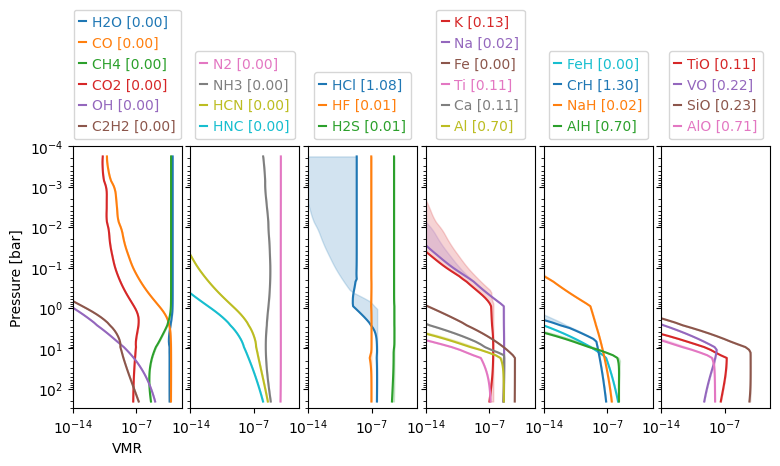

In [9]:
FC, FC_simple = calculate_chemistry(T=temperature, print_elapsed_time=True)

species_names = {
    'H2O1':'H2O', 'C1O1':'CO', 'C1H4':'CH4', 'C1O2':'CO2', 'H1O1':'OH', 'C2H2':'C2H2',
    'Cl1H1':'HCl', 'F1H1':'HF', 'H2S1':'H2S', 'N2':'N2', 'H3N1':'NH3',
    'Fe1H1':'FeH', 'Cr1H1':'CrH', 'H1Na1':'NaH', 'Al1H1':'AlH',
    'O1Ti1':'TiO', 'O1V1':'VO', 'O1Si1':'SiO', 'Al1O1':'AlO', 
    'C1H1N1_hcn':'HCN', 'C1H1N1_hnc':'HNC'
}
panels = [
    ['H2O1', 'C1O1', 'C1H4', 'C1O2', 'H1O1', 'C2H2'], 
    ['N2', 'H3N1', 'C1H1N1_hcn', 'C1H1N1_hnc'], 
    ['Cl1H1', 'F1H1', 'H2S1'], 
    ['K', 'Na', 'Fe', 'Ti', 'Ca', 'Al'], 
    ['Fe1H1', 'Cr1H1', 'H1Na1', 'Al1H1'], 
    ['O1Ti1', 'O1V1', 'O1Si1', 'Al1O1'], 
]
# P_mask = (FC.pressures > 0.3)
# P_mask = None
P_mask = (FC.pressures > 1.) & (FC.pressures < 10.)

ncols = len(panels)
width_ratios = [0.2,]*ncols# + [0.45,]

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=ncols, wspace=0.08, width_ratios=width_ratios)
ax = np.array([
    fig.add_subplot(gs[i]) for i in range(ncols)
])
i = 0
for species_i, ax_i in zip(panels, ax):
    for species_j in species_i:
        VMR, VMR_simple, RMSE = get_VMRs_and_RMSE(FC, FC_simple, species_j, P_mask=P_mask)

        color = f'C{i}'
        label = species_names.get(species_j, species_j)
        label = f'{label} [{RMSE:.2f}]'

        # Plot the VMRs
        line = ax_i.plot(VMR, FC.pressures, label=label, color=color)
        ax_i.fill_betweenx(FC.pressures, VMR, VMR_simple, color=line[0].get_color(), alpha=0.2)
        
        i += 1

    # Set the y-axis to log scale and set limits
    ax_i.set(xscale='log', yscale='log', ylim=(3e2,1e-4), xlim=(1e-14,1e-2))
    ax_i.legend(loc='lower center', bbox_to_anchor=(0.5,1.), labelcolor='linecolor', handlelength=0.5, handletextpad=0.4)

for ax_i in ax[1:]:
    ax_i.set(yticklabels=[])

ax[0].set(xlabel='VMR', ylabel='Pressure [bar]')

plt.show()

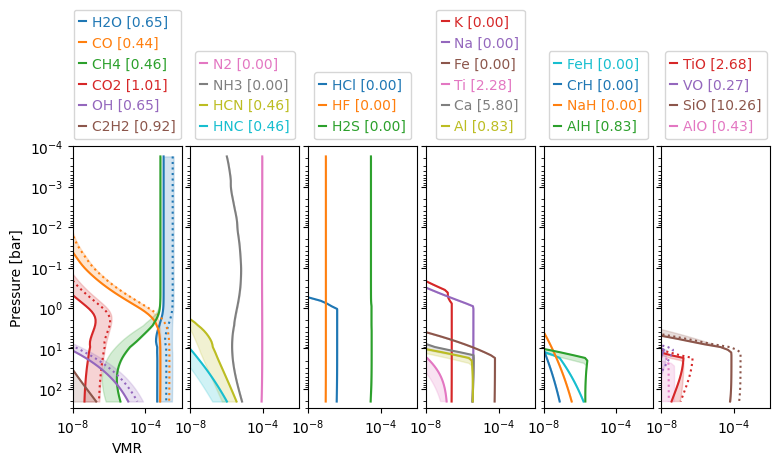

In [31]:
FC_1 = FastChemistry(pressures=pressure, logK_gas_file='logK_simplified.dat', logK_cond_file='logK_condensates_simplified.dat')
FC_1(T=temperature)

FC_2 = FastChemistry(pressures=pressure, logK_gas_file='logK_simplified.dat', logK_cond_file='logK_condensates_simplified.dat')
FC_2(T=temperature, el_abund={'O':10**(8.85+0.5-12)})

ncols = len(panels)
width_ratios = [0.2,]*ncols# + [0.45,]

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=ncols, wspace=0.08, width_ratios=width_ratios)
ax = np.array([
    fig.add_subplot(gs[i]) for i in range(ncols)
])
i = 0
for species_i, ax_i in zip(panels, ax):
    for species_j in species_i:
        VMR_1, VMR_2, RMSE = get_VMRs_and_RMSE(FC_1, FC_2, species_j)

        color = f'C{i}'
        label = species_names.get(species_j, species_j)
        label = f'{label} [{RMSE:.2f}]'

        # Plot the VMRs
        line = ax_i.plot(VMR_1, FC_1.pressures, label=label, color=color)
        ax_i.fill_betweenx(FC_1.pressures, VMR_1, VMR_2, color=line[0].get_color(), alpha=0.2)

        if 'O1' in species_j:
            ax_i.plot(VMR_1*10**0.5, FC_1.pressures, color=color, ls=':')
        elif 'O2' in species_j:
            ax_i.plot(VMR_1*10**0.5*2, FC_1.pressures, color=color, ls=':')

        i += 1

    # Set the y-axis to log scale and set limits
    ax_i.set(xscale='log', yscale='log', ylim=(3e2,1e-4), xlim=(1e-8,1e-2))
    ax_i.legend(loc='lower center', bbox_to_anchor=(0.5,1.), labelcolor='linecolor', handlelength=0.5, handletextpad=0.4)

for ax_i in ax[1:]:
    ax_i.set(yticklabels=[])

ax[0].set(xlabel='VMR', ylabel='Pressure [bar]')

plt.show()

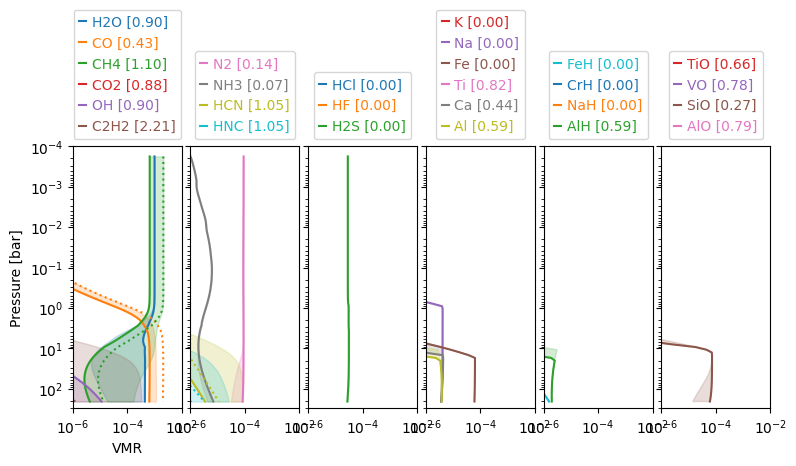

In [33]:
FC_1 = FastChemistry(pressures=pressure, logK_gas_file='logK_simplified.dat', logK_cond_file='logK_condensates_simplified.dat')
FC_1(T=temperature)

FC_2 = FastChemistry(pressures=pressure, logK_gas_file='logK_simplified.dat', logK_cond_file='logK_condensates_simplified.dat')
FC_2(T=temperature, el_abund={'C':10**(8.60+0.5-12)})

ncols = len(panels)
width_ratios = [0.2,]*ncols# + [0.45,]

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=ncols, wspace=0.08, width_ratios=width_ratios)
ax = np.array([
    fig.add_subplot(gs[i]) for i in range(ncols)
])
i = 0
for species_i, ax_i in zip(panels, ax):
    for species_j in species_i:
        VMR_1, VMR_2, RMSE = get_VMRs_and_RMSE(FC_1, FC_2, species_j)

        color = f'C{i}'
        label = species_names.get(species_j, species_j)
        label = f'{label} [{RMSE:.2f}]'

        # Plot the VMRs
        line = ax_i.plot(VMR_1, FC_1.pressures, label=label, color=color)
        ax_i.fill_betweenx(FC_1.pressures, VMR_1, VMR_2, color=line[0].get_color(), alpha=0.2)

        if 'C1' in species_j:
            ax_i.plot(VMR_1*10**0.5, FC_1.pressures, color=color, ls=':')
        elif 'C2' in species_j:
            ax_i.plot(VMR_1*10**0.5*2, FC_1.pressures, color=color, ls=':')

        i += 1

    # Set the y-axis to log scale and set limits
    ax_i.set(xscale='log', yscale='log', ylim=(3e2,1e-4), xlim=(1e-6,1e-2))
    ax_i.legend(loc='lower center', bbox_to_anchor=(0.5,1.), labelcolor='linecolor', handlelength=0.5, handletextpad=0.4)

for ax_i in ax[1:]:
    ax_i.set(yticklabels=[])

ax[0].set(xlabel='VMR', ylabel='Pressure [bar]')

plt.show()

In [ ]:
# P_mask = (FC.pressures > 1.) & (FC.pressures < 10.)
P_mask = None
XH = np.arange(-0.8,0.8+1e-6,0.1)

3.267 | 0.184 seconds
3.614 | 0.200 seconds
3.487 | 0.205 seconds
3.737 | 0.206 seconds
3.439 | 0.200 seconds
3.739 | 0.197 seconds
3.542 | 0.200 seconds
3.575 | 0.217 seconds
3.343 | 0.219 seconds
3.472 | 0.199 seconds
3.308 | 0.228 seconds
3.454 | 0.226 seconds
3.730 | 0.229 seconds
3.500 | 0.228 seconds
3.826 | 0.229 seconds
3.910 | 0.233 seconds
4.152 | 0.237 seconds
4.389 | 0.217 seconds
4.266 | 0.241 seconds
4.268 | 0.248 seconds
4.458 | 0.239 seconds
4.338 | 0.250 seconds
4.419 | 0.227 seconds
4.443 | 0.254 seconds
4.351 | 0.233 seconds
4.247 | 0.232 seconds
Failed element conservation
3.978 | 0.236 seconds
Failed element conservation
3.846 | 0.239 seconds
Failed element conservation
3.964 | 0.238 seconds
Failed element conservation
4.071 | 0.242 seconds
Failed element conservation
4.110 | 0.241 seconds


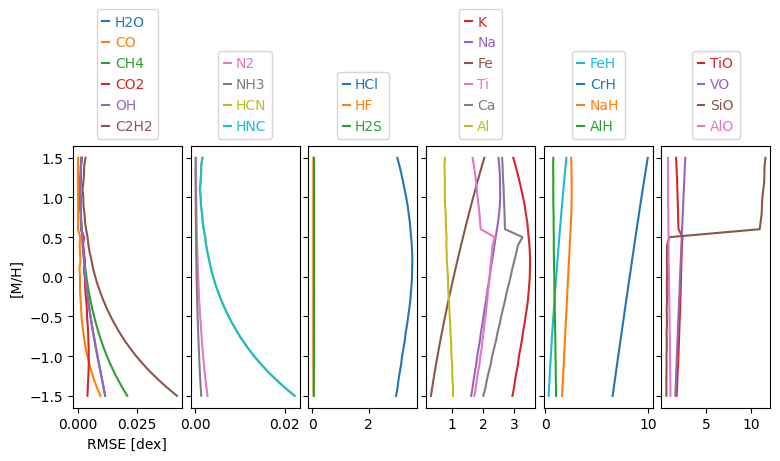

In [10]:
P_mask = None
XH = np.arange(-1.5,1.5+1e-6,0.1)

RMSE = {species_i: np.nan*np.ones_like(XH) for species_i in np.concatenate(panels)}
for i, XH_val in enumerate(XH):
    FC, FC_simple = calculate_chemistry(T=temperature, FeH=XH_val, print_elapsed_time=True)
    for species_i in np.concatenate(panels):
        *_, RMSE[species_i][i] = get_VMRs_and_RMSE(FC, FC_simple, species_i, P_mask=P_mask)

ncols = len(panels)
width_ratios = [0.2,]*ncols# + [0.45,]

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=ncols, wspace=0.08, width_ratios=width_ratios)
ax = np.array([
    fig.add_subplot(gs[i]) for i in range(ncols)
])

i = 0
for species_i, ax_i in zip(panels, ax):
    for species_j in species_i:
        ax_i.plot(RMSE[species_j], XH, color=f'C{i}', label=species_names.get(species_j, species_j))
        i += 1

    ax_i.legend(loc='lower center', bbox_to_anchor=(0.5,1.), labelcolor='linecolor', handlelength=0.5, handletextpad=0.4)

for ax_i in ax[1:]:
    ax_i.set(yticklabels=[])

ax[0].set(xlabel='RMSE [dex]', ylabel=f'[M/H]')
plt.show()

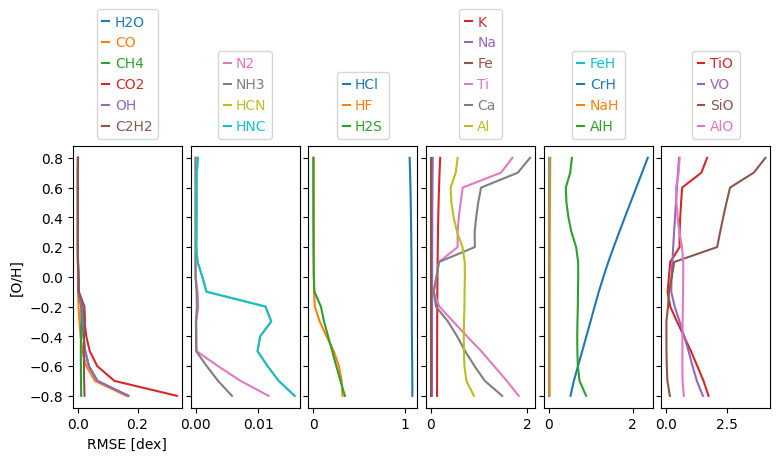

In [9]:
element = 'O'

RMSE = {species_i: np.nan*np.ones_like(XH) for species_i in np.concatenate(panels)}
for i, XH_val in enumerate(XH):
    FC, FC_simple = calculate_chemistry(T=temperature, XH={element:XH_val})
    for species_i in np.concatenate(panels):
        *_, RMSE[species_i][i] = get_VMRs_and_RMSE(FC, FC_simple, species_i, P_mask=P_mask)

ncols = len(panels)
width_ratios = [0.2,]*ncols# + [0.45,]

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=ncols, wspace=0.08, width_ratios=width_ratios)
ax = np.array([
    fig.add_subplot(gs[i]) for i in range(ncols)
])

i = 0
for species_i, ax_i in zip(panels, ax):
    for species_j in species_i:
        ax_i.plot(RMSE[species_j], XH, color=f'C{i}', label=species_names.get(species_j, species_j))
        i += 1

    ax_i.legend(loc='lower center', bbox_to_anchor=(0.5,1.), labelcolor='linecolor', handlelength=0.5, handletextpad=0.4)

for ax_i in ax[1:]:
    ax_i.set(yticklabels=[])

ax[0].set(xlabel='RMSE [dex]', ylabel=f'[{element}/H]')
plt.show()

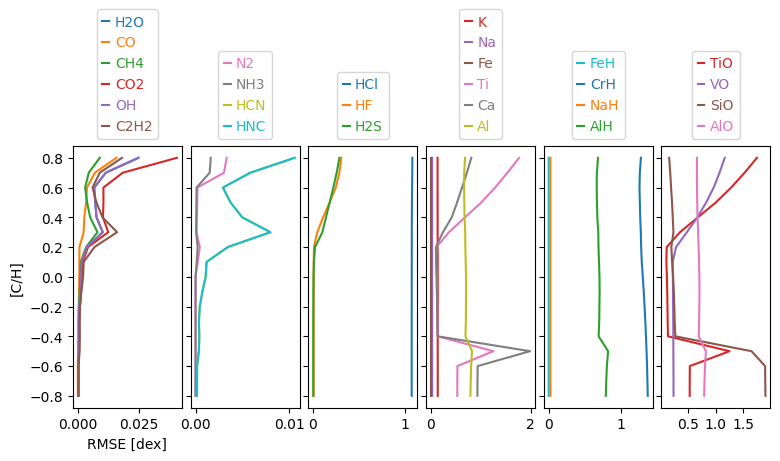

In [10]:
element = 'C'

RMSE = {species_i: np.nan*np.ones_like(XH) for species_i in np.concatenate(panels)}
for i, XH_val in enumerate(XH):
    FC, FC_simple = calculate_chemistry(T=temperature, XH={element:XH_val})
    for species_i in np.concatenate(panels):
        *_, RMSE[species_i][i] = get_VMRs_and_RMSE(FC, FC_simple, species_i, P_mask=P_mask)

ncols = len(panels)
width_ratios = [0.2,]*ncols# + [0.45,]

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=ncols, wspace=0.08, width_ratios=width_ratios)
ax = np.array([
    fig.add_subplot(gs[i]) for i in range(ncols)
])

i = 0
for species_i, ax_i in zip(panels, ax):
    for species_j in species_i:
        ax_i.plot(RMSE[species_j], XH, color=f'C{i}', label=species_names.get(species_j, species_j))
        i += 1

    ax_i.legend(loc='lower center', bbox_to_anchor=(0.5,1.), labelcolor='linecolor', handlelength=0.5, handletextpad=0.4)

for ax_i in ax[1:]:
    ax_i.set(yticklabels=[])

ax[0].set(xlabel='RMSE [dex]', ylabel=f'[{element}/H]')
plt.show()

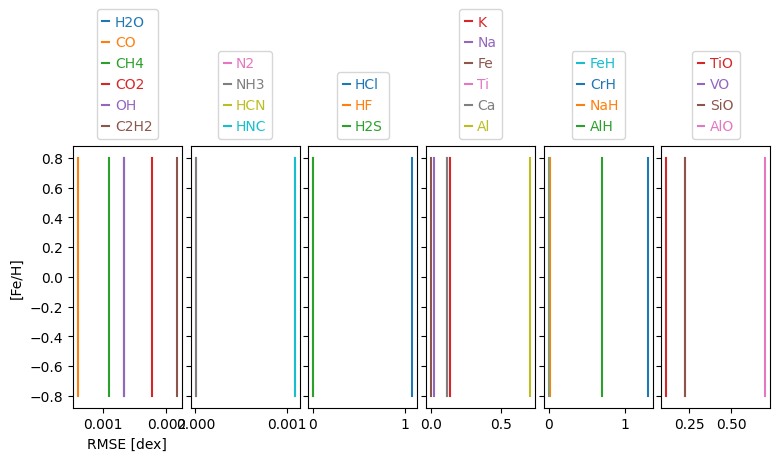

In [11]:
element = 'Fe'

RMSE = {species_i: np.nan*np.ones_like(XH) for species_i in np.concatenate(panels)}
for i, XH_val in enumerate(XH):
    FC, FC_simple = calculate_chemistry(T=temperature, XH={element:XH_val})
    for species_i in np.concatenate(panels):
        *_, RMSE[species_i][i] = get_VMRs_and_RMSE(FC, FC_simple, species_i, P_mask=P_mask)

ncols = len(panels)
width_ratios = [0.2,]*ncols# + [0.45,]

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=ncols, wspace=0.08, width_ratios=width_ratios)
ax = np.array([
    fig.add_subplot(gs[i]) for i in range(ncols)
])

i = 0
for species_i, ax_i in zip(panels, ax):
    for species_j in species_i:
        ax_i.plot(RMSE[species_j], XH, color=f'C{i}', label=species_names.get(species_j, species_j))
        i += 1

    ax_i.legend(loc='lower center', bbox_to_anchor=(0.5,1.), labelcolor='linecolor', handlelength=0.5, handletextpad=0.4)

for ax_i in ax[1:]:
    ax_i.set(yticklabels=[])

ax[0].set(xlabel='RMSE [dex]', ylabel=f'[{element}/H]')
plt.show()

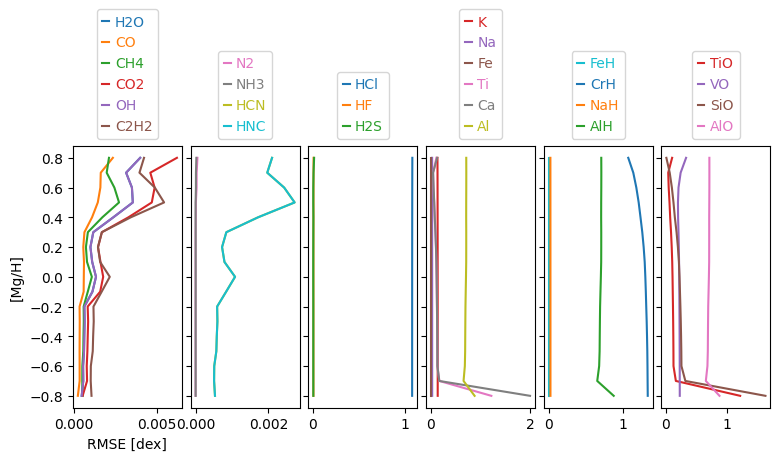

In [12]:
element = 'Mg'

RMSE = {species_i: np.nan*np.ones_like(XH) for species_i in np.concatenate(panels)}
for i, XH_val in enumerate(XH):
    FC, FC_simple = calculate_chemistry(T=temperature, XH={element:XH_val})
    for species_i in np.concatenate(panels):
        *_, RMSE[species_i][i] = get_VMRs_and_RMSE(FC, FC_simple, species_i, P_mask=P_mask)

ncols = len(panels)
width_ratios = [0.2,]*ncols# + [0.45,]

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=ncols, wspace=0.08, width_ratios=width_ratios)
ax = np.array([
    fig.add_subplot(gs[i]) for i in range(ncols)
])

i = 0
for species_i, ax_i in zip(panels, ax):
    for species_j in species_i:
        ax_i.plot(RMSE[species_j], XH, color=f'C{i}', label=species_names.get(species_j, species_j))
        i += 1

    ax_i.legend(loc='lower center', bbox_to_anchor=(0.5,1.), labelcolor='linecolor', handlelength=0.5, handletextpad=0.4)

for ax_i in ax[1:]:
    ax_i.set(yticklabels=[])

ax[0].set(xlabel='RMSE [dex]', ylabel=f'[{element}/H]')
plt.show()

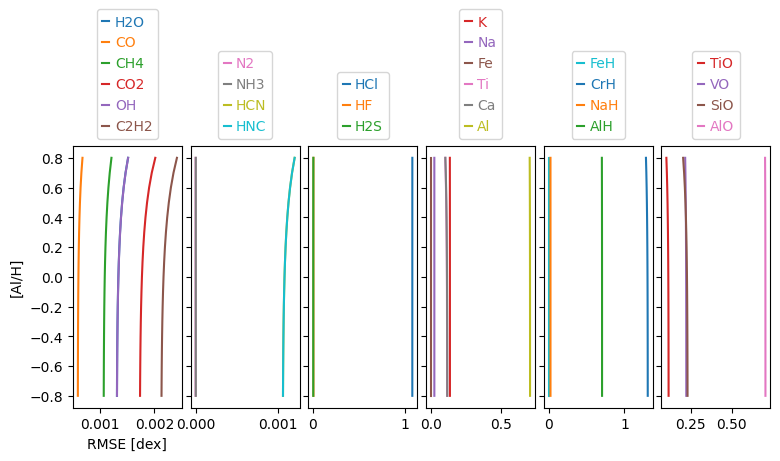

In [13]:
element = 'Al'

RMSE = {species_i: np.nan*np.ones_like(XH) for species_i in np.concatenate(panels)}
for i, XH_val in enumerate(XH):
    FC, FC_simple = calculate_chemistry(T=temperature, XH={element:XH_val})
    for species_i in np.concatenate(panels):
        *_, RMSE[species_i][i] = get_VMRs_and_RMSE(FC, FC_simple, species_i, P_mask=P_mask)

ncols = len(panels)
width_ratios = [0.2,]*ncols# + [0.45,]

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=ncols, wspace=0.08, width_ratios=width_ratios)
ax = np.array([
    fig.add_subplot(gs[i]) for i in range(ncols)
])

i = 0
for species_i, ax_i in zip(panels, ax):
    for species_j in species_i:
        ax_i.plot(RMSE[species_j], XH, color=f'C{i}', label=species_names.get(species_j, species_j))
        i += 1

    ax_i.legend(loc='lower center', bbox_to_anchor=(0.5,1.), labelcolor='linecolor', handlelength=0.5, handletextpad=0.4)

for ax_i in ax[1:]:
    ax_i.set(yticklabels=[])

ax[0].set(xlabel='RMSE [dex]', ylabel=f'[{element}/H]')
plt.show()

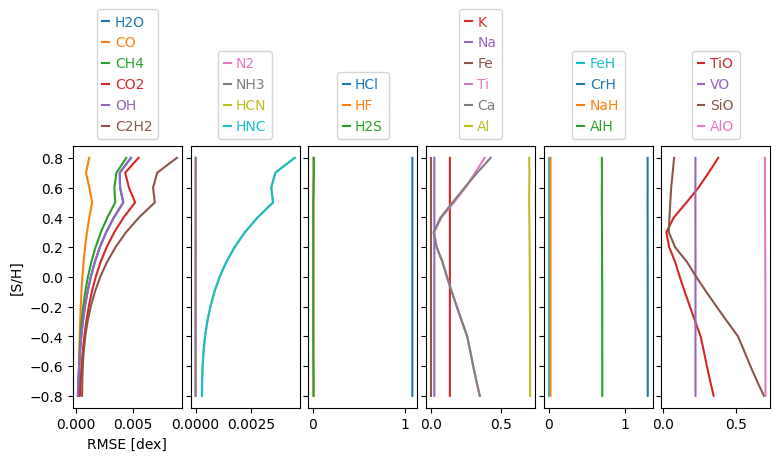

In [14]:
element = 'S'

RMSE = {species_i: np.nan*np.ones_like(XH) for species_i in np.concatenate(panels)}
for i, XH_val in enumerate(XH):
    FC, FC_simple = calculate_chemistry(T=temperature, XH={element:XH_val})
    for species_i in np.concatenate(panels):
        *_, RMSE[species_i][i] = get_VMRs_and_RMSE(FC, FC_simple, species_i, P_mask=P_mask)

ncols = len(panels)
width_ratios = [0.2,]*ncols# + [0.45,]

fig = plt.figure(figsize=(9,3.4))
gs = fig.add_gridspec(nrows=1, ncols=ncols, wspace=0.08, width_ratios=width_ratios)
ax = np.array([
    fig.add_subplot(gs[i]) for i in range(ncols)
])

i = 0
for species_i, ax_i in zip(panels, ax):
    for species_j in species_i:
        ax_i.plot(RMSE[species_j], XH, color=f'C{i}', label=species_names.get(species_j, species_j))
        i += 1

    ax_i.legend(loc='lower center', bbox_to_anchor=(0.5,1.), labelcolor='linecolor', handlelength=0.5, handletextpad=0.4)

for ax_i in ax[1:]:
    ax_i.set(yticklabels=[])

ax[0].set(xlabel='RMSE [dex]', ylabel=f'[{element}/H]')
plt.show()

In [ ]:
species_to_plot = ['H2O1', 'C1O1', 'Fe1H1', 'C1H4', 'H2S1', 'F1H1', 'Cr1H1', 'K', 'Na', 'Fe', 'O1Ti1', 'O1Si1', 'O1V1', 'Al1H1', 'Ca1H1', 'Cl1H1', 'H1Na1', 'Al1O1']
fig, ax = plt.subplots(figsize=(8,6))

for species_i in species_to_plot:
    vmr = FC.get_VMR(species_i)
    line, = ax.plot(vmr, FC.pressures, label=f'{species_i}')

    # vmr_wo_rainout = FC_wo_rainout.get_VMR(species_i)
    # ax.plot(vmr_wo_rainout, FC_wo_rainout.pressures, '--', c=line.get_color(), alpha=0.6)

    # vmr_Asplund = FC_Asplund.get_VMR(species_i)
    # ax.plot(vmr_Asplund, FC_Asplund.pressures, ':', c=line.get_color(), alpha=0.6)

    vmr_simple = FC_simple.get_VMR(species_i)
    ax.plot(vmr_simple, FC_simple.pressures, ':', c=line.get_color(), alpha=0.6, lw=2)

    if np.isnan(vmr_simple).any():
        print(f'Warning: {species_i} has NaN values in simplified model')

# ax.plot(FC.get_VMR('K') + FC.get_VMR('H1K1O1'), FC.pressures, 'k--', label='K + KH')

# ax.plot(FC.get_VMR('Cl1K1'), FC.pressures, 'k--', label='KCl')

ax.legend()
ax.set(xscale='log', yscale='log', xlim=(1e-11,1e-1), ylim=(3e2,1e-4), ylabel='Pressure [bar]', xlabel='VMR')

'''
ax2 = ax.twiny()
ax2.plot(
    np.array(FC.output.element_cond_degree)[::-1,FC.fastchem.getElementIndex('K')], FC.pressures, c='k'
)
ax2.plot(
    np.array(FC_simple.output.element_cond_degree)[::-1,FC_simple.fastchem.getElementIndex('K')], FC.pressures, 'k:'
)
# '''

plt.show()

fig, ax = plt.subplots(figsize=(4,6))
line, = ax.plot(
    (FC.get_VMR('C1O1')+FC.get_VMR('C1H4'))/(FC.get_VMR('H2O1')+FC.get_VMR('C1O1')), FC.pressures, label='C/O',
)
ax.plot(
    (FC_simple.get_VMR('C1O1')+FC_simple.get_VMR('C1H4'))/(FC_simple.get_VMR('H2O1')+FC_simple.get_VMR('C1O1')), 
    FC_simple.pressures, ':', c=line.get_color(), alpha=0.6, lw=2, label='C/O (simplified)',
)

line, = ax.plot(
    (FC.get_VMR('N2')+FC.get_VMR('H3N1'))/(FC.get_VMR('C1O1')+FC.get_VMR('C1H4')), FC.pressures, label='N/C',
)
ax.plot(
    (FC_simple.get_VMR('N2')+FC_simple.get_VMR('H3N1'))/(FC_simple.get_VMR('C1O1')+FC_simple.get_VMR('C1H4')), 
    FC_simple.pressures, ':', c=line.get_color(), alpha=0.6, lw=2, label='N/C (simplified)',
)

ax.set(yscale='log', ylim=(3e2,1e-4), ylabel='Pressure [bar]', xlabel='C/O ratio')
# ax.set_xlim(0,0.2)
ax.set_xlim(0.58,0.68)
plt.show()

In [ ]:
def get_formed_condensates(self, species_i):

    formed_condensates = {}
    max_number_density = 0
    with open(self.logK_cond_file, 'r') as f:
        lines = f.readlines()

        for line in lines:
            if ':' not in line:
                continue
            if f' {species_i} ' not in line:
                continue

            cond_species = line.split(' ')[0]
            cond_number_density = self.get_condensate_number_density(cond_species)
            if (cond_number_density != 0.).any():
                formed_condensates[cond_species] = np.log10(cond_number_density.max())
                if formed_condensates[cond_species] > max_number_density:
                    max_number_density = formed_condensates[cond_species]

    # cond_species = list(formed_condensates.keys())
    # for cond_species_i in cond_species:
    #     if formed_condensates[cond_species_i] < 0.5*max_number_density:
    #         del formed_condensates[cond_species_i]

    return formed_condensates

print(get_formed_condensates(FC, 'O'))
print(get_formed_condensates(FC_simple, 'O'))
# print(get_formed_condensates(FC, 'Mg'), get_formed_condensates(FC_simple, 'Mg'))
# print(get_formed_condensates(FC, 'Fe'), get_formed_condensates(FC_simple, 'Fe'))

In [ ]:
print(get_formed_condensates(FC, 'K'), get_formed_condensates(FC_simple, 'K'))
print(get_formed_condensates(FC, 'Cl'), get_formed_condensates(FC_simple, 'Cl'))

print(get_formed_condensates(FC, 'Al'), get_formed_condensates(FC_simple, 'Al'))

In [ ]:
print(get_formed_condensates(FC, 'Cr'), get_formed_condensates(FC_simple, 'Cr'))

In [ ]:
fig, ax = plt.subplots(figsize=(4,6))

def plot_element_condensation_degree(self, element, **kwargs):
    index = self.fastchem.getElementIndex(element)
    cond_degree = np.array(self.output.element_cond_degree)[::-1,index]

    line, = ax.plot(cond_degree, self.pressures, label=element, **kwargs)
    return line

# line = plot_element_condensation_degree(FC, 'O')
# plot_element_condensation_degree(FC_simple, 'O', c=line.get_color(), alpha=0.6, lw=2, linestyle=':')

# line = plot_element_condensation_degree(FC, 'Mg')
# plot_element_condensation_degree(FC_simple, 'Mg', c=line.get_color(), alpha=0.6, lw=2, linestyle=':')

# line = plot_element_condensation_degree(FC, 'Si')
# plot_element_condensation_degree(FC_simple, 'Si', c=line.get_color(), alpha=0.6, lw=2, linestyle=':')


# line = plot_element_condensation_degree(FC, 'Na')
# plot_element_condensation_degree(FC_simple, 'Na', c=line.get_color(), alpha=0.6, lw=2, linestyle=':')

line = plot_element_condensation_degree(FC, 'Cl')
plot_element_condensation_degree(FC_simple, 'Cl', c=line.get_color(), alpha=0.6, lw=2, linestyle=':')

line = plot_element_condensation_degree(FC, 'K')
plot_element_condensation_degree(FC_simple, 'K', c=line.get_color(), alpha=0.6, lw=2, linestyle=':')

ax.set(yscale='log', ylim=(1e2,1e-4), ylabel='Pressure [bar]')
# ax.set_xlim(0,0.2)
plt.show()